In [ ]:
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold,RFECV
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RepeatedStratifiedKFold,StratifiedKFold
from sklearn.tree import export_graphviz
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn.externals.six import StringIO

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import re
import seaborn as sns
!pip install graphviz
!pip install -U imbalanced-learn

import graphviz
import matplotlib.pyplot as plt

startup_df = pd.read_csv("startup_data.csv", delimiter=',', header = 0, encoding = "ISO-8859-1",skipinitialspace=True)
startup_df = startup_df.rename(columns={'market ': 'market', 'funding_total_usd ': 'funding_total_usd'})
startup_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54294 entries, 0 to 54293
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   permalink             49438 non-null  object 
 1   name                  49437 non-null  object 
 2   homepage_url          45989 non-null  object 
 3   category_list         45477 non-null  object 
 4   market                45470 non-null  object 
 5   funding_total_usd     49438 non-null  object 
 6   status                48124 non-null  object 
 7   country_code          44165 non-null  object 
 8   state_code            30161 non-null  object 
 9   region                44165 non-null  object 
 10  city                  43322 non-null  object 
 11  funding_rounds        49438 non-null  float64
 12  founded_at            38554 non-null  object 
 13  founded_month         38482 non-null  object 
 14  founded_quarter       38482 non-null  object 
 15  founded_year       

In [19]:
format_date = ('founded_at','first_funding_at','last_funding_at')
for i in format_date:
  startup_df[i] = pd.to_datetime(startup_df[i], format = '%Y-%m-%d', errors = 'coerce')
startup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54294 entries, 0 to 54293
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   permalink             49438 non-null  object        
 1   name                  49437 non-null  object        
 2   homepage_url          45989 non-null  object        
 3   category_list         45477 non-null  object        
 4   market                45470 non-null  object        
 5   funding_total_usd     49438 non-null  object        
 6   status                48124 non-null  object        
 7   country_code          44165 non-null  object        
 8   state_code            30161 non-null  object        
 9   region                44165 non-null  object        
 10  city                  43322 non-null  object        
 11  funding_rounds        49438 non-null  float64       
 12  founded_at            38553 non-null  datetime64[ns]
 13  founded_month   

In [20]:
startup_df.describe()

,funding_rounds,founded_year,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
count,49438.000000,38482.000000,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,...,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04
mean,1.696205,2007.359129,2.173215e+05,7.501051e+06,6.163322e+03,1.302213e+05,2.336410e+04,1.888157e+06,6.541898e+04,1.628453e+05,...,3.845592e+04,7.074227e+03,1.243955e+06,1.492891e+06,1.205356e+06,7.375261e+05,3.424682e+05,1.697692e+05,5.767067e+04,1.423197e+04
std,1.294213,7.579203,1.056985e+06,2.847112e+07,1.999048e+05,2.981404e+06,1.432046e+06,1.382046e+08,6.582908e+05,5.612088e+06,...,3.864461e+06,4.282166e+05,5.531974e+06,7.472704e+06,7.993592e+06,9.815218e+06,5.406915e+06,6.277905e+06,5.252312e+06,2.716865e+06
min,1.000000,1902.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,2006.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000,2010.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000,2012.000000,2.500000e+04,5.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,18.000000,2014.000000,1.300000e+08,2.351000e+09,2.500000e+07,2.924328e+08,3.000000e+08,3.007950e+10,6.359026e+07,7.505000e+08,...,6.806116e+08,7.200000e+07,3.190000e+08,5.420000e+08,4.900000e+08,1.200000e+09,4.000000e+08,1.060000e+09,1.000000e+09,6.000000e+08


In [21]:
#To reduce the complexity, while processing the date variable fields, we convert the actual dates to 
#relative dates, describing the distance from founded to first and last funding and then drop the founded date.

startup_df['age_first_funding'] = (startup_df['first_funding_at']-startup_df['founded_at'])/pd.Timedelta(days=365)
startup_df['age_last_funding'] = (startup_df['last_funding_at']-startup_df['founded_at'])/pd.Timedelta(days=365)
startup_df['founded_month'] = pd.DatetimeIndex(startup_df['founded_at']).month
startup_df['founded_quarter'] = pd.DatetimeIndex(startup_df['founded_at']).quarter
startup_df.isnull().sum()

permalink                4856
name                     4857
homepage_url             8305
category_list            8817
market                   8824
funding_total_usd        4856
status                   6170
country_code            10129
state_code              24133
region                  10129
city                    10972
funding_rounds           4856
founded_at              15741
founded_month           15741
founded_quarter         15741
founded_year            15812
first_funding_at         4866
last_funding_at          4862
seed                     4856
venture                  4856
equity_crowdfunding      4856
undisclosed              4856
convertible_note         4856
debt_financing           4856
angel                    4856
grant                    4856
private_equity           4856
post_ipo_equity          4856
post_ipo_debt            4856
secondary_market         4856
product_crowdfunding     4856
round_A                  4856
round_B                  4856
round_C   

In [22]:


# Assuming this is the code to calculate 'age_first_funding'
startup_df['age_first_funding'] = (startup_df['first_funding_at'] - startup_df['founded_at']) / pd.Timedelta(days=365)

# Now, check if 'age_first_funding' is successfully created
if 'age_first_funding' in startup_df.columns:
    # Remove rows with null values in specific central variables
    central_vars = ['status', 'founded_month', 'founded_year', 'market', 'country_code', 'funding_total_usd', 'age_first_funding']
    startup_df = startup_df.dropna(subset=central_vars)

    # Display the remaining number of observations
    num_observations = startup_df.shape[0]
    print(f"With removal of rows containing null values in central variables, {num_observations} observations remain.")
else:
    print("'age_first_funding' column not found. Please check the code for calculating 'age_first_funding'.")


With removal of rows containing null values in central variables, 33147 observations remain.


# EDA

In [ ]:
# Create Visualizations

# Histogram
# Explore categorical variables
categorical_columns = ['state_code', 'category_list', 'status']
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=col, hue='status')
    plt.title(f'{col} by Status')
    plt.xticks(rotation=45)
    plt.show()
    plt.savefig(f'{col}_by_status.png', bbox_inches='tight')
    plt.close()

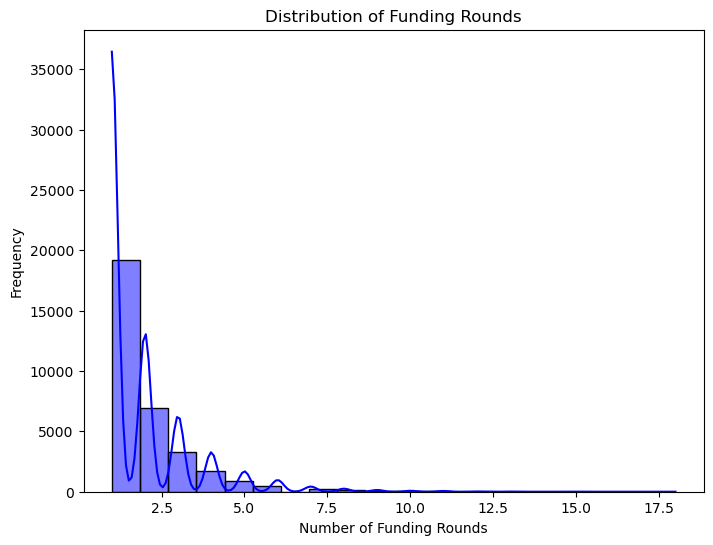

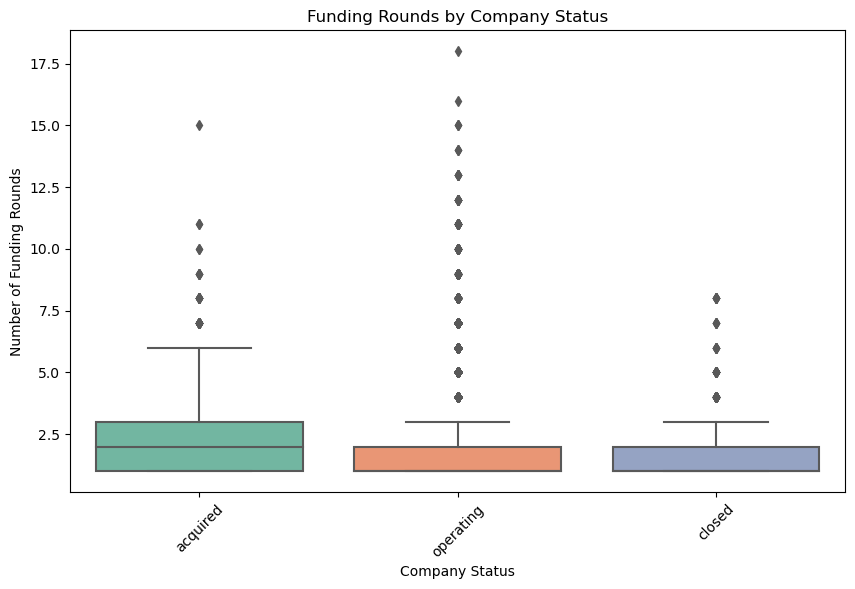

In [25]:
df=startup_df
plt.figure(figsize=(8, 6))
sns.histplot(df['funding_rounds'], bins=20, kde=True, color='blue')
plt.xlabel('Number of Funding Rounds')
plt.ylabel('Frequency')
plt.title('Distribution of Funding Rounds')
plt.show()

# Box plot of 'funding_rounds' by 'status'
plt.figure(figsize=(10, 6))
sns.boxplot(x='status', y='funding_rounds', data=df, palette='Set2')
plt.xlabel('Company Status')
plt.ylabel('Number of Funding Rounds')
plt.title('Funding Rounds by Company Status')
plt.xticks(rotation=45)
plt.show()

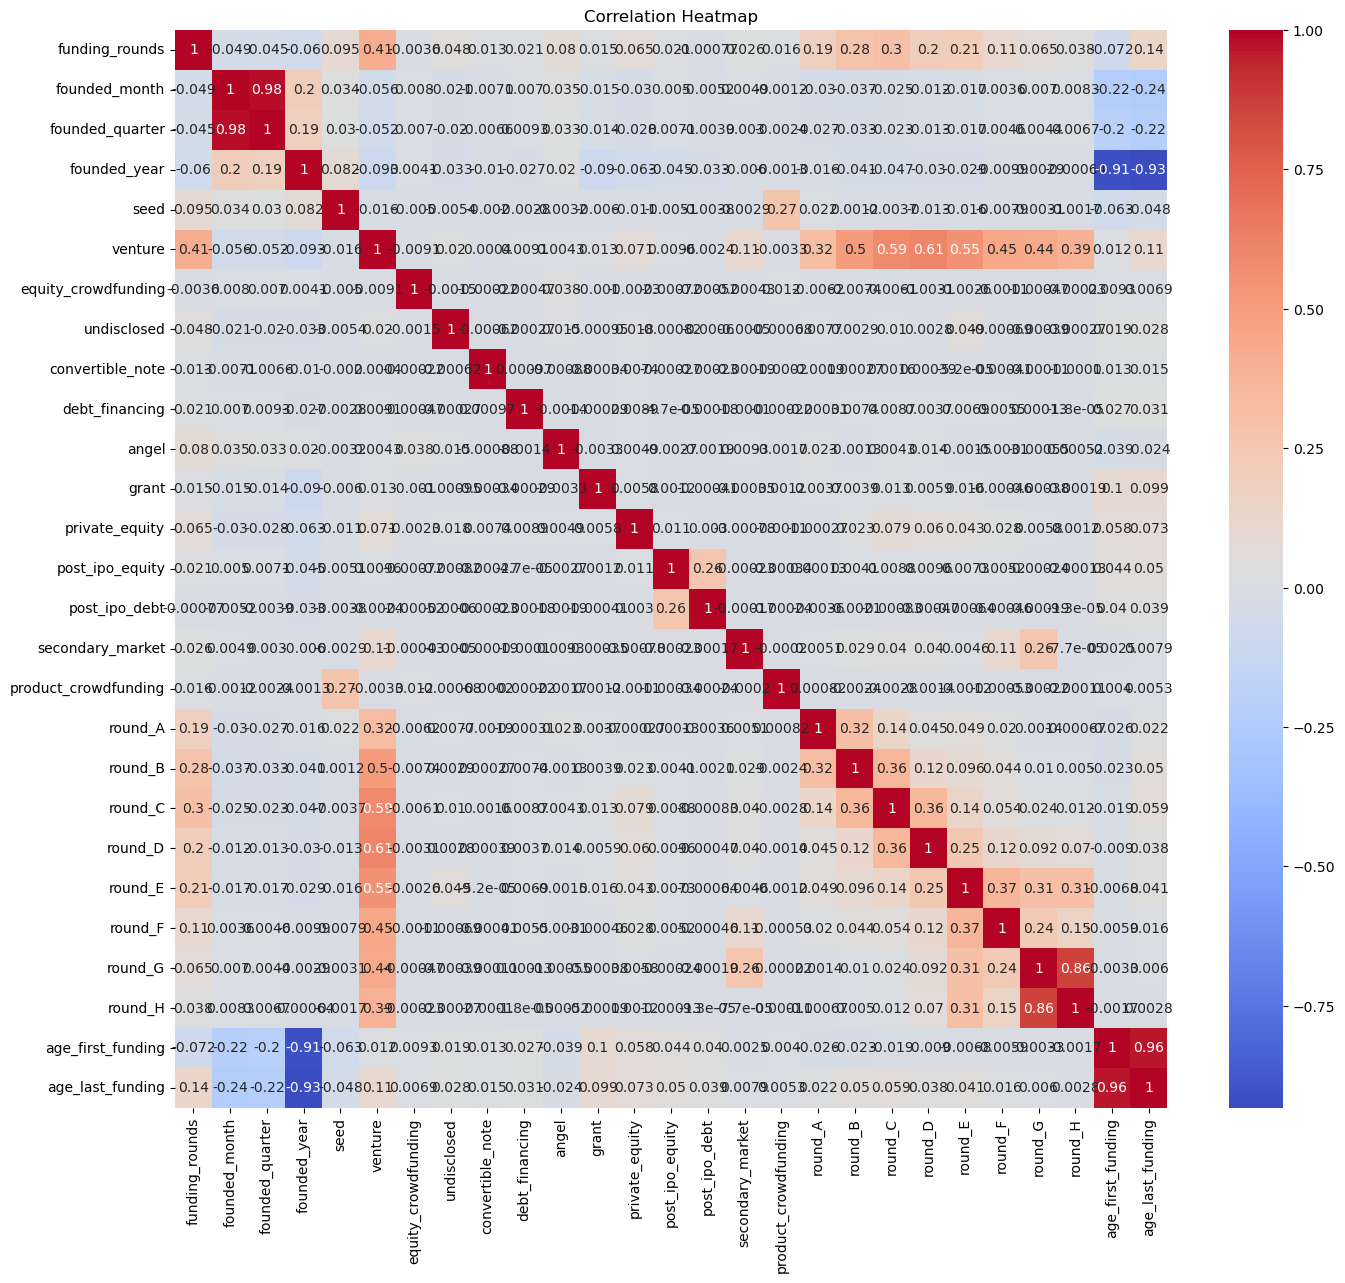

In [26]:
plt.figure(figsize=(16, 14))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap')
plt.show()
plt.savefig("Correlation.png")
plt.close()

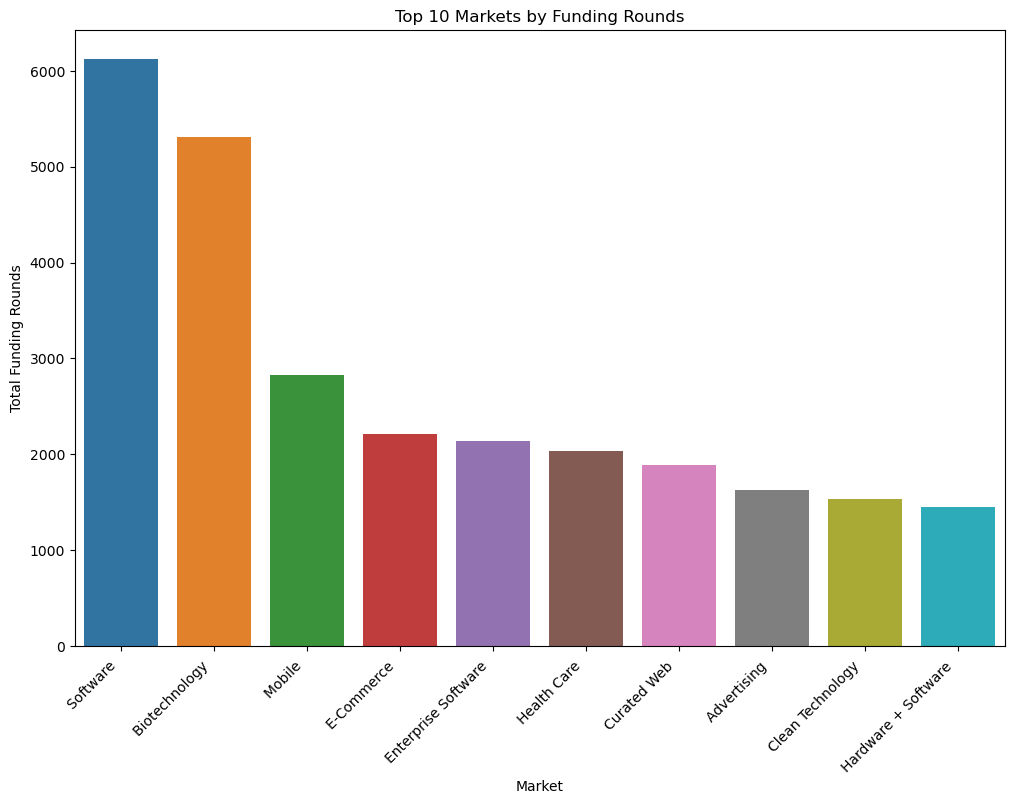

In [31]:

top_markets = df.groupby('market')['funding_rounds'].sum().sort_values(ascending=False).head(10)

# Bar chart for the top 10 markets
plt.figure(figsize=(12, 8))
sns.barplot(x=top_markets.index, y=top_markets.values)
plt.title('Top 10 Markets by Funding Rounds')
plt.xlabel('Market')
plt.ylabel('Total Funding Rounds')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()



In [32]:
# Excluding irrelevant variables assumed not useful for predicting startup success
# Funding_total_USD is excluded, as it is an aggregation of angel and seed

columns_to_drop = [
    'permalink',
#     'name',  # not yet sure if i want to keep the 'name' column
    'homepage_url',
    'state_code',
    'region',
    'city',
    'founded_at',
    'first_funding_at',
    'funding_total_usd',
    'last_funding_at',
    'category_list'
]

startup_df = startup_df.drop(columns=columns_to_drop)


In [33]:
startup_df = startup_df.drop_duplicates()
startup_df.shape

(33147, 31)

In [34]:
# Create a new column 'total_investment' by summing values from specific investment columns
startup_df['total_investment'] = startup_df[['seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 
                                              'debt_financing', 'angel', 'grant', 'private_equity', 'post_ipo_equity', 
                                              'post_ipo_debt', 'secondary_market', 'product_crowdfunding']].sum(axis=1)

# Display descriptive statistics for the 'total_investment' column
total_investment_stats = startup_df['total_investment'].describe()
print(total_investment_stats)


count    3.314700e+04
mean     1.508289e+07
std      1.797496e+08
min      0.000000e+00
25%      1.025240e+05
50%      1.345389e+06
75%      8.425772e+06
max      3.007950e+10
Name: total_investment, dtype: float64


In [35]:
startup_df.shape

(33147, 32)

In [36]:
#remove extreme values (outliers) from the 'total_investment' column.
Q1 = startup_df['total_investment'].quantile(0.25)
Q3 = startup_df['total_investment'].quantile(0.75)
IQR = Q3 - Q1

fund_lower = (Q1 - 1.5 * IQR)
fund_upper = (Q3 + 1.5 * IQR)

startup_df = startup_df[
    (startup_df['total_investment'] >= fund_lower) 
    & (startup_df['total_investment'] <= fund_upper)
]

#keeps the top 20 markets and groups the remaining ones into the 'Other' category in the 'market' column.
top10_markets = startup_df['market'].value_counts()[:10].keys().tolist()
startup_df['market'] = startup_df['market'].apply(lambda i: i if i in top10_markets else 'Other')

#Set negative values in the 'age_first_funding' and 'age_last_funding' columns are set to zero.
startup_df.loc[startup_df['age_first_funding'] < 0, 'age_first_funding'] = 0
startup_df.loc[startup_df['age_last_funding'] < 0, 'age_last_funding'] = 0

#Keep only the data where the 'founded_year' is greater than or equal to 1995
#Drop Unnecessary Columns
startup_df = startup_df[(startup_df['founded_year'] >= 2000.0)]
startup_df = startup_df.drop(['country_code', 'name'], axis=1)



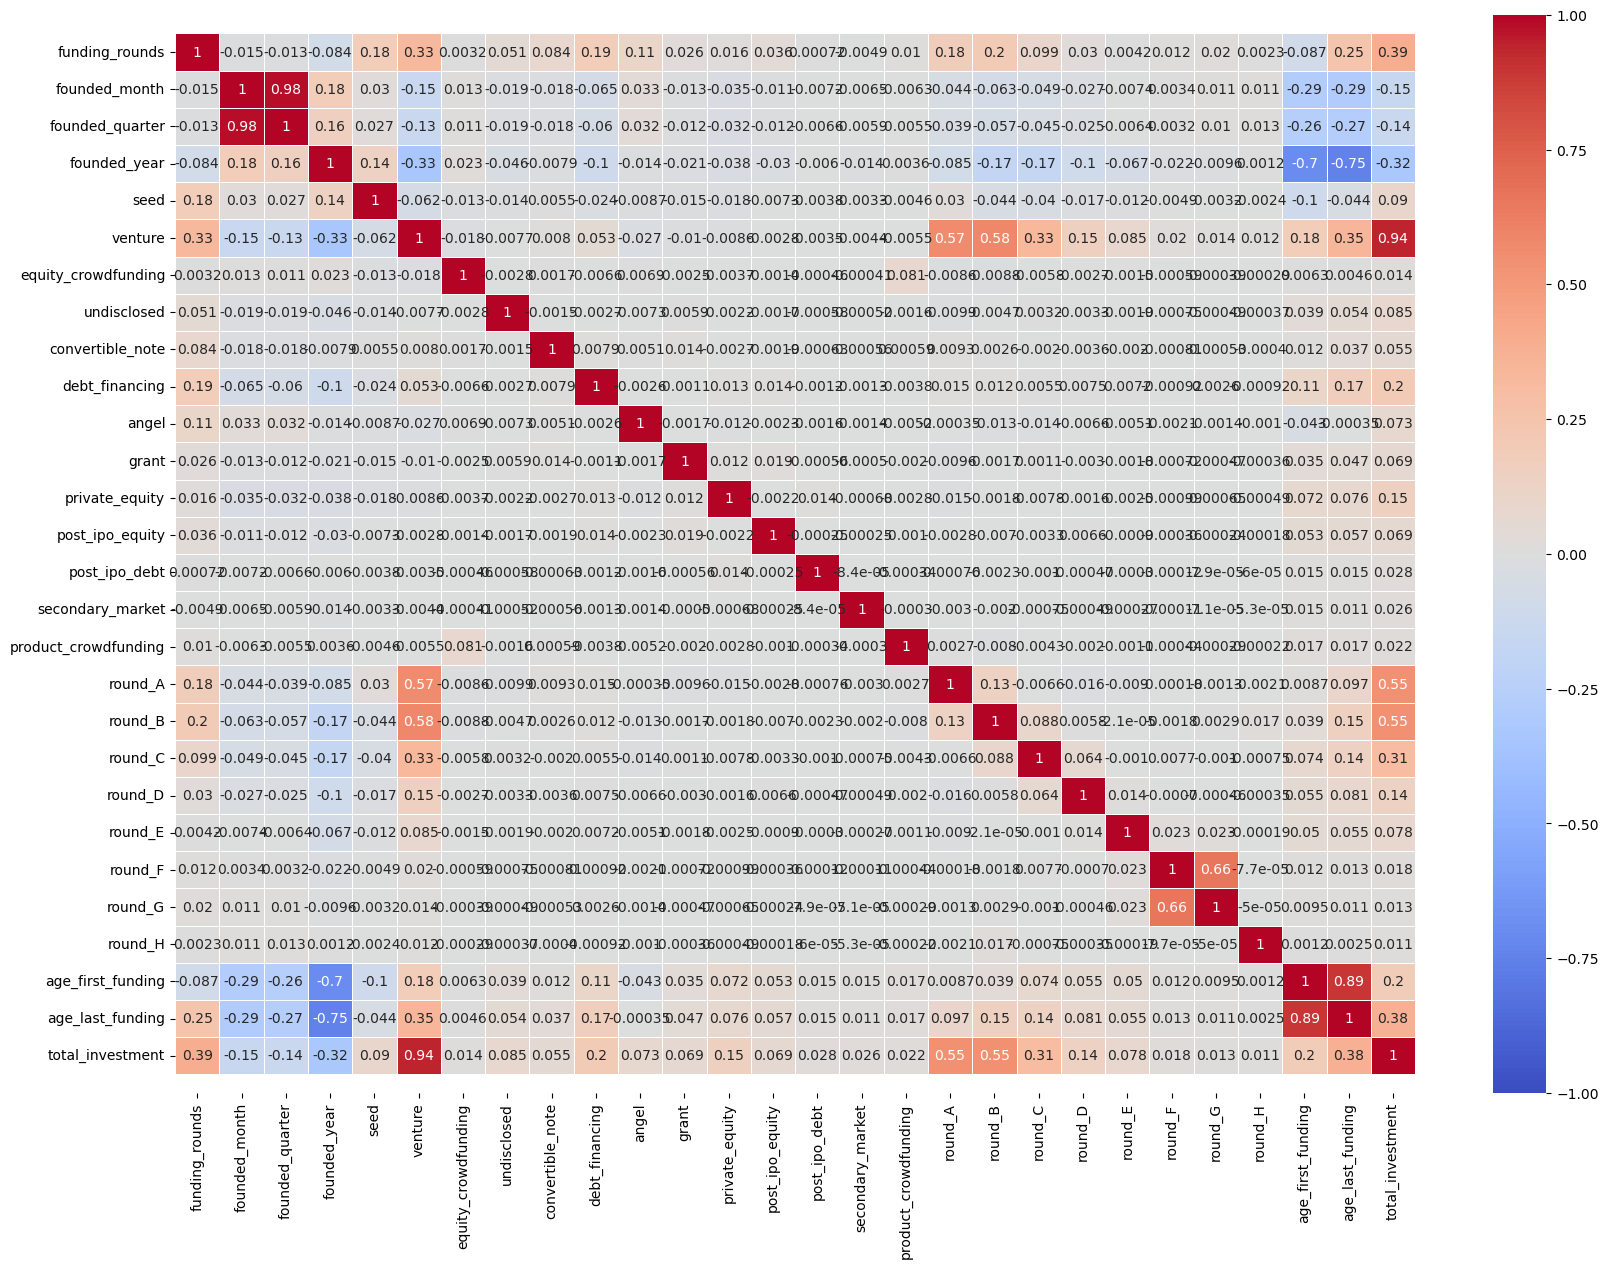

In [12]:

# Set the figure size
plt.figure(figsize=(20, 14))

# Calculate the correlation matrix for the DataFrame
correlation_matrix = startup_df.corr()

# Create a heatmap using seaborn
heatmap = sns.heatmap(correlation_matrix, annot=True, linewidths=0.5, cmap='coolwarm', vmin=-1, vmax=1)

# Adjust the ylim to fix the seaborn plot cut-off issue
bottom, top = heatmap.get_ylim()
heatmap.set_ylim(bottom + 0.5, top - 0.5)

# Display the heatmap
plt.show()


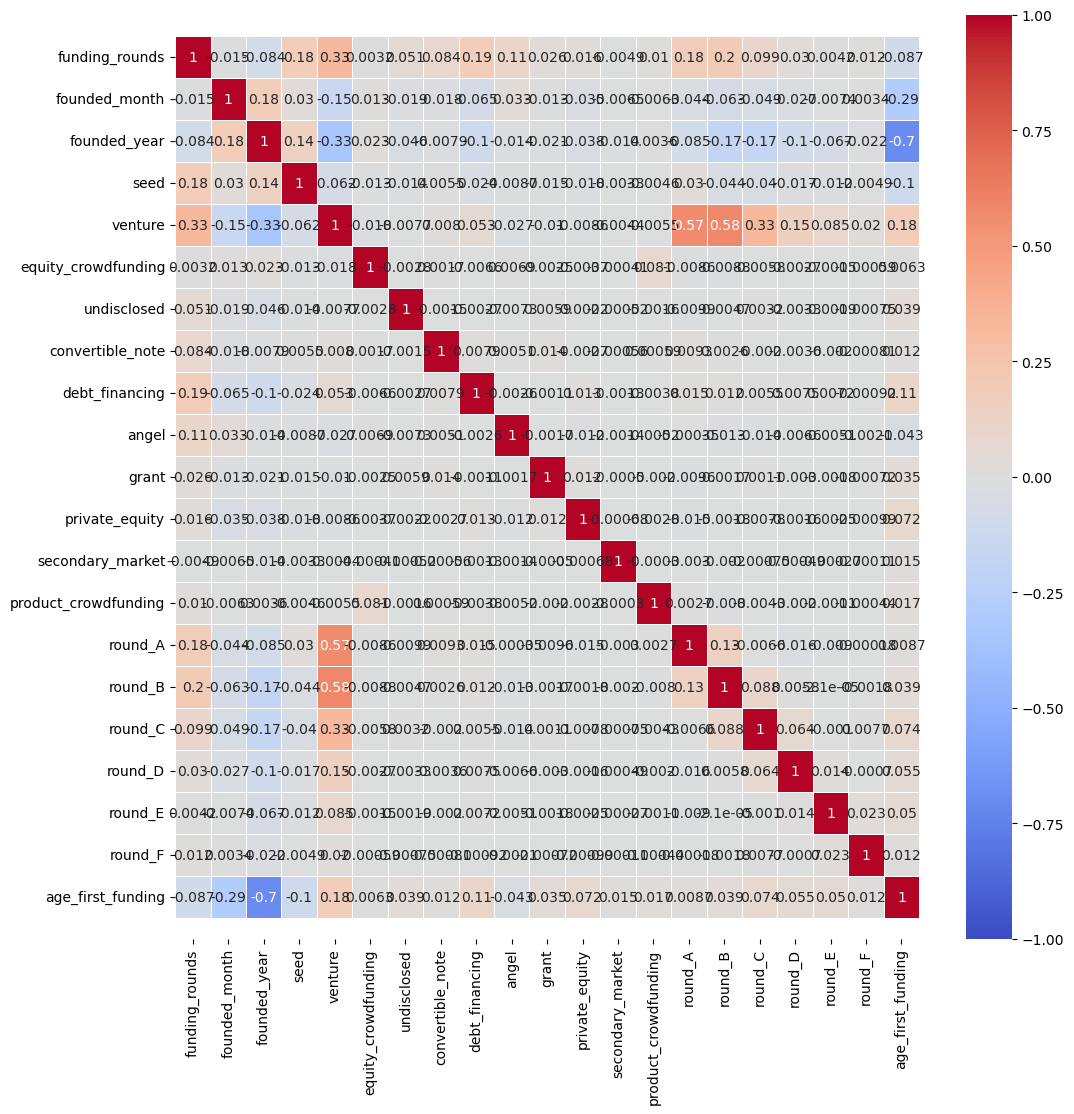

In [37]:
# Drop specified columns from the DataFrame
columns_to_drop = [
    'post_ipo_equity', 'post_ipo_debt', 'round_G', 'round_H',
    'founded_quarter', 'total_investment', 'age_last_funding'
]
startup_df = startup_df.drop(columns=columns_to_drop, axis=1)

# Create a heatmap to visualize the correlation between columns in the DataFrame
plt.figure(figsize=(12, 12))
startup_heatmap = sns.heatmap(startup_df.corr(), annot=True, linewidth=0.5, cmap='coolwarm', vmin=-1, vmax=1)

# Adjust the limits of the heatmap to display the full content
bottom, top = startup_heatmap.get_ylim()
startup_heatmap.set_ylim(bottom + 0.5, top - 0.5)

# Show the heatmap
plt.show()


In [38]:
startup_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26310 entries, 0 to 49435
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   market                26310 non-null  object 
 1   status                26310 non-null  object 
 2   funding_rounds        26310 non-null  float64
 3   founded_month         26310 non-null  float64
 4   founded_year          26310 non-null  float64
 5   seed                  26310 non-null  float64
 6   venture               26310 non-null  float64
 7   equity_crowdfunding   26310 non-null  float64
 8   undisclosed           26310 non-null  float64
 9   convertible_note      26310 non-null  float64
 10  debt_financing        26310 non-null  float64
 11  angel                 26310 non-null  float64
 12  grant                 26310 non-null  float64
 13  private_equity        26310 non-null  float64
 14  secondary_market      26310 non-null  float64
 15  product_crowdfundin

In [39]:
print('Original classification from dataset')

# Count and display the original distribution of 'status'
original_distribution = startup_df['status'].value_counts().reset_index().rename(columns={'index': 'status', 'status': 'count'})
display(original_distribution.sort_values(by=['status'], ascending=False))

# Map 'status' to binary values (0 for 'closed', 1 for 'acquired')
status_dict = {"closed": 0, "acquired": 1}
startup_df = startup_df[(startup_df['status'] == 'acquired') | (startup_df['status'] == 'closed')]
startup_df["status_binary"] = startup_df["status"].map(status_dict)
startup_df = startup_df.drop(['status'], axis=1)

print('Modified classification')

# Count and display the modified distribution of 'status_binary'
modified_distribution = startup_df['status_binary'].value_counts().reset_index().rename(columns={'index': 'status_binary', 'status_binary': 'count'})
display(modified_distribution.sort_values(by=['status_binary'], ascending=True))

Original classification from dataset


,status,count
0,operating,23043
2,closed,1525
1,acquired,1742


Modified classification


,status_binary,count
1,0,1525
0,1,1742


In [40]:
startup_df.to_csv('model_df.csv', index=False)

# Display a message indicating that the DataFrame has been saved
print('Modified DataFrame saved as modelling_df.csv')

Modified DataFrame saved as modelling_df.csv


In [41]:
modelling_df = startup_df.copy()
startup_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3267 entries, 0 to 49419
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   market                3267 non-null   object 
 1   funding_rounds        3267 non-null   float64
 2   founded_month         3267 non-null   float64
 3   founded_year          3267 non-null   float64
 4   seed                  3267 non-null   float64
 5   venture               3267 non-null   float64
 6   equity_crowdfunding   3267 non-null   float64
 7   undisclosed           3267 non-null   float64
 8   convertible_note      3267 non-null   float64
 9   debt_financing        3267 non-null   float64
 10  angel                 3267 non-null   float64
 11  grant                 3267 non-null   float64
 12  private_equity        3267 non-null   float64
 13  secondary_market      3267 non-null   float64
 14  product_crowdfunding  3267 non-null   float64
 15  round_A             


# RANDOM FOREST


In [ ]:
## Copy the DataFrame for modeling
modelling_df = startup_df.copy()

# One-hot encode categorical variables and prepare features (X) and target variable (y)
X = pd.get_dummies(modelling_df.drop(['status_binary'], axis=1))
y = modelling_df['status_binary']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

# Test different numbers of estimators for RandomForestClassifier
n_estimators_list = list(range(10, 201, 10))

# Iterate over different numbers of estimators
for n in n_estimators_list:
    # Create a RandomForestClassifier with n_estimators trees
    model = RandomForestClassifier(n_estimators=n)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Print the training and testing scores for the current model
    print('{} Estimators - Train Score: {:.3f} | Test Score: {:.3f}'.format(n, model.score(X_train, y_train), model.score(X_test, y_test)))



In [ ]:
# Generate a classification report
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
classification_report_result = classification_report(y_test, y_pred)

# Print the classification report
print("\nClassification Report:\n", classification_report_result)

In [ ]:


y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute the False Positive Rate (fpr), True Positive Rate (tpr), and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.3f})".format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance

# Compute permutation importance for feature ranking
permutation_result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=0)

# Create a Series to hold feature importances, sorted in descending order
feature_importances = pd.Series(permutation_result.importances_mean, index=X_train.columns.values).sort_values(ascending=False)

# Display feature importances
print("Feature Importances:")
print(feature_importances)


In [ ]:
# Perform Recursive Feature Elimination with Cross-Validation (RFECV)
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X_train, y_train)


In [ ]:
# Plot the correlation between the number of attributes and the accuracy of the model
plt.figure(figsize=(9, 5))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], linewidth=3)
plt.title('The correlation between the number of attributes and the accuracy of the model')
plt.xlabel('Number of Attributes')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Select features using Recursive Feature Elimination with Cross-Validation (RFECV)
selected_features = X_train.columns[rfecv.support_]

# Drop non-selected features from the feature matrix X
X.drop(X_train.columns[~rfecv.support_], axis=1, inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Fit the model using the training data
model.fit(X_train, y_train)

# Evaluate feature importance using permutation importance
result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=0)

# Create a Series of feature importances sorted in descending order
feature_importances = pd.Series(result.importances_mean, index=X_train.columns.values).sort_values(ascending=False)

# Display the feature importances
print("Feature Importances:")
print(feature_importances)


In [ ]:

# Sort the importance scores in descending order
sorted_fimp = feature_importances.sort_values(ascending=False)

# Create a horizontal bar plot using seaborn
sns.barplot(x=sorted_fimp.values, y=sorted_fimp.index, color='skyblue')

# Set the size of the figure
plt.rcParams['figure.figsize'] = 8, 10

# Set labels for the x-axis and y-axis
plt.xlabel('Importance Score')
plt.ylabel('Attribute')

# Set the title of the plot
plt.title('Attribute Importance')

# Display the plot
plt.show()


In [ ]:
# Step 1: Make predictions on the test set and calculate ROC curve and AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Predict probabilities for positive class
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)  # Compute ROC curve
auc = metrics.roc_auc_score(y_test, y_pred_proba)  # Calculate AUC
plt.plot(fpr, tpr, label="Data 1, AUC=" + str(auc))  # Plot ROC curve
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()



In [ ]:
# Step 2: Evaluate model performance using cross-validation

cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cross_val, n_jobs=-1, error_score='raise')


In [ ]:

# Step 3: Report performance metrics
print('Average accuracy across 10-fold cross-validation repeated 5 times: {:.3f}% with a standard deviation of: {:.3f}'.format(
    np.mean(scores) * 100, np.std(scores)))



In [ ]:
# Step 4: Make a single prediction on a random sample from the test set
pred = X_test.sample(n=1)
outcome = model.predict(pred)
print('Predicted Class: {}'.format(outcome[0]))


In [ ]:

# Step 5: Display the prediction and associated confidence
if outcome == 1:
    print('This startup is predicted to be successful with {:.1f}% confidence.'.format(np.mean(scores) * 100))
    display(pred)
elif outcome == 0:
    print('This startup is predicted NOT to be successful with {:.1f}% confidence.'.format(np.mean(scores) * 100))
    display(pred)




# LOGISTIC REGRESSION


In [ ]:
# Data Preparation
X = pd.get_dummies(modelling_df.drop(['status_binary'], axis=1))
y = modelling_df['status_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


In [ ]:

# Logistic Regression without Class Balancing
logreg = LogisticRegressionCV(max_iter=10000, scoring='roc_auc')
logreg.fit(X_train, y_train)

# Evaluate and Print Results
print('Logistic Regression without Class Balancing:')
print('Training Accuracy: {:.4f}'.format(logreg.score(X_train, y_train)))
print('Test Accuracy: {:.4f}'.format(logreg.score(X_test, y_test)))


In [ ]:

# Plot ROC Curve
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="AUC = {:.4f}".format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()



In [ ]:
# Logistic Regression with Balanced Class Weights
logreg = LogisticRegressionCV(max_iter=10000, scoring='roc_auc', class_weight='balanced')
logreg.fit(X_train, y_train)

# Evaluate and Print Results
print('\nLogistic Regression with Balanced Class Weights:')
print('Training Accuracy: {:.4f}'.format(logreg.score(X_train, y_train)))
print('Test Accuracy: {:.4f}'.format(logreg.score(X_test, y_test)))


In [ ]:
# Logistic Regression with L1 Penalty and Liblinear Solver (Balanced Class Weights)
logreg = LogisticRegressionCV(penalty='l1', solver='liblinear', scoring='roc_auc', class_weight='balanced', max_iter=100000)
logreg.fit(X_train, y_train)

# Evaluate and Print Results
print('\nLogistic Regression with L1 Penalty and Liblinear Solver (Balanced Class Weights):')
print('Training Accuracy: {:.4f}'.format(logreg.score(X_train, y_train)))
print('Test Accuracy: {:.4f}'.format(logreg.score(X_test, y_test)))


In [ ]:
#lassification Report for the model with balanced class weights
y_pred_balanced = logreg.predict(X_test)
print('\nClassification Report for Balanced Model:')
print(classification_report(y_test, y_pred_balanced))

In [ ]:

# Logistic Regression with L1 Penalty and Liblinear Solver (No Class Balancing)
logreg = LogisticRegressionCV(penalty='l1', solver='liblinear', max_iter=10000, scoring='roc_auc')
logreg.fit(X_train, y_train)

# Evaluate and Print Results
print('\nLogistic Regression with L1 Penalty and Liblinear Solver (No Class Balancing):')
print('Training Accuracy: {:.4f}'.format(logreg.score(X_train, y_train)))
print('Test Accuracy: {:.4f}'.format(logreg.score(X_test, y_test)))


In [ ]:
# Plot ROC Curve for the Final Model
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="AUC = {:.4f}".format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
modelling_df.groupby('status_binary').agg({'status_binary':'count'})


# KNN with SMOTE


In [ ]:

# Data Preparation
X = pd.get_dummies(modelling_df.drop(['status_binary'], axis=1))
y = modelling_df['status_binary']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [ ]:
# Standardize the features (important for KNN)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


In [ ]:

# K-Nearest Neighbors (KNN) Classifier
k_value = 5  # You can choose an appropriate value for k
knn_classifier = KNeighborsClassifier(n_neighbors=k_value)



In [ ]:
# Fit the model to the resampled training data
knn_classifier.fit(X_train_resampled, y_train_resampled)

# Evaluate and Print Results
print('KNN with SMOTE:')
print('Training Accuracy: {:.4f}'.format(knn_classifier.score(X_train_resampled, y_train_resampled)))
print('Test Accuracy: {:.4f}'.format(knn_classifier.score(X_test_scaled, y_test)))




In [ ]:
# Confusion Matrix
y_pred = knn_classifier.predict(X_test_scaled)
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix:\n', conf_matrix)

In [ ]:
# Classification Report
class_report = metrics.classification_report(y_test, y_pred)
print('\nClassification Report:\n', class_report)


In [ ]:
# ROC Curve
y_pred_proba = knn_classifier.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="AUC = {:.4f}".format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


#  XGBoost


In [ ]:
# Importing necessary libraries
!pip install xgboost
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [ ]:
# Data Preparation
X = pd.get_dummies(modelling_df.drop(['status_binary'], axis=1))
y = modelling_df['status_binary']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Create and train the XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

# Display classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))


In [ ]:

# Standardize the features (assuming numerical features)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# XGBoost model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',  # You can also use 'auc' for ROC AUC
    use_label_encoder=False  # To avoid warnings, since 'use_label_encoder' will be deprecated
)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

In [ ]:
# XGBoost model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',  # You can also use 'auc' for ROC AUC
    use_label_encoder=False  # To avoid warnings, since 'use_label_encoder' will be deprecated
)

# Train the model
xgb_model.fit(X_train_scaled, y_train)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Evaluate and print results
train_accuracy = xgb_model.score(X_train_scaled, y_train)
test_accuracy = xgb_model.score(X_test_scaled, y_test)

print('XGBoost Model:')
print('Training Accuracy: {:.4f}'.format(train_accuracy))
print('Test Accuracy: {:.4f}'.format(test_accuracy))



In [ ]:
# Confusion matrix
y_pred = xgb_model.predict(X_test_scaled)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix:')
print(confusion_matrix)


In [ ]:

# Classification report
classification_report = metrics.classification_report(y_test, y_pred)
print('\nClassification Report:')
print(classification_report)


In [ ]:
# Plot ROC Curve
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label="AUC = {:.4f}".format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve')
plt.show()


# ADABoost

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame 'modelling_df' with features and labels
# Replace 'status_binary' with the actual name of your binary target column
X = pd.get_dummies(modelling_df.drop(['status_binary'], axis=1))
y = modelling_df['status_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Train AdaBoostClassifier
ada_model = AdaBoostClassifier(n_estimators=50, random_state=42)
ada_model.fit(X_train, y_train)

# Plot feature importance
feature_importance = ada_model.feature_importances_
sorted_idx = feature_importance.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(X_train.shape[1]), feature_importance[sorted_idx])
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('AdaBoost Classifier - Feature Importance')
plt.show()

# Predict probabilities for the positive class
y_prob = ada_model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, y_prob)
print(f'AUC: {auc:.3f}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Generate confusion matrix
y_pred = ada_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Acquired', 'Acquired'], yticklabels=['Not Acquired', 'Acquired'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
classification_report_result = classification_report(y_test, y_pred, digits=3)
print("\nClassification Report:\n", classification_report_result)


# XGBOOST

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation
X = pd.get_dummies(modelling_df.drop(['status_binary'], axis=1))
y = modelling_df['status_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Initialize XGBoost Classifier
model = XGBClassifier()

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc_score = roc_auc_score(y_test, y_proba)
print("AUC: {:.3f}".format(auc_score))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.3f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
classification_report_result = classification_report(y_test, y_pred, digits=3)
print("\nClassification Report:\n", classification_report_result)


# KNN

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Data Preparation
X = pd.get_dummies(modelling_df.drop(['status_binary'], axis=1))
y = modelling_df['status_binary']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_smote, y_train_smote)

# Predictions
y_pred = knn.predict(X_test)

# Print classification report with 3 decimal places
classification_report_result = classification_report(y_test, y_pred, digits=3)
print("\nClassification Report:\n", classification_report_result)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Plot ROC Curve
y_prob = knn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
